In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import Autoencoder
from solver import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [20]:
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [21]:
test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data)
    test_images.append(data)
    test_labels.append(target)

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
test_images = test_images.squeeze(1)

### Activation Maximization

In [22]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

### Load Model

In [23]:
size_ls = [4, 4, 4, 4, 4, 10,
        10, 10, 10, 10, 16, 16,
        16, 16, 16, 16, 16, 24,
        24, 24, 24, 24, 24, 24, 
        32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32, 32, 32, 32, 32, 
        32, 32]

In [24]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

### RFA

In [70]:
sae_rf_ls_all = []
dae_rf_ls_all = []

for i in range(10):
    modelpath = f'/home/david/sparsify_models/l_models/{i}'
    epoch = 49

    data = torch.randn(28, 28)
    data = data.unsqueeze(0)
    input = data.view(data.size(0), -1)
    input.requires_grad_(True)

    sae = load_model(modelpath, 'SAE', epoch)
    dae = load_model(modelpath, 'DAE', epoch)

    layer_name = 'bottle_neck'
    sae_activation_dictionary = {}
    dae_activation_dictionary = {}

    sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))
    dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

    sae_rf_ls = []
    for i in range(32):
        output = amu.act_max(network=sae,
                        input=input,
                        layer_activation=sae_activation_dictionary,
                        layer_name=layer_name,
                        unit=i,
                        steps=steps,
                        alpha=alpha,
                        verbose=verbose,
                        L2_Decay=L2_Decay,
                        Gaussian_Blur=Gaussian_Blur,
                        Norm_Crop=Norm_Crop,
                        Contrib_Crop=Contrib_Crop,
                        )
        sae_rf_ls.append(output.detach().numpy())

    srf_freq_ls = []
    for srf in sae_rf_ls:
        radial_avg = power_spectrum_radial_average(z_score(srf.reshape(28, 28)))
        srf_freq_ls.append(radial_avg)

    sae_rf_ls_all.append(srf_freq_ls)

    dae_rf_ls = []
    for i in range(size_ls[epoch]):
        output = amu.act_max(network=dae,
                        input=input,
                        layer_activation=dae_activation_dictionary,
                        layer_name=layer_name,
                        unit=i,
                        steps=steps,
                        alpha=alpha,
                        verbose=verbose,
                        L2_Decay=L2_Decay,
                        Gaussian_Blur=Gaussian_Blur,
                        Norm_Crop=Norm_Crop,
                        Contrib_Crop=Contrib_Crop,
                        )
        dae_rf_ls.append(output.detach().numpy())

    drf_freq_ls = []
    for drf in dae_rf_ls:
        radial_avg = power_spectrum_radial_average(z_score(drf.reshape(28, 28)))
        drf_freq_ls.append(radial_avg)

    dae_rf_ls_all.append(drf_freq_ls)

avg_sae_rf = np.mean(sae_rf_ls_all, axis=0)
avg_dae_rf = np.mean(dae_rf_ls_all, axis=0)

/tmp/ipykernel_8637/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


In [26]:
def z_score(image):
    """
    Normalize an image using the z-score normalization.
    Normalized image: (pixel - mean) / std
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())

    radialprofile = tbin / nr

    return radialprofile

def power_spectrum_radial_average(image):
    """
    Calculate the radial average of the power spectrum for a 2D grey-scale image.
    :param image: 2D numpy array representing the image
    :return: radial average of the power spectrum
    """
    # Take the 2D Fourier transform of the image and shift the zero frequency component to the center
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = np.abs(f_transform) ** 2

    # Compute the radial profile of the power spectrum
    radial_avg = radial_profile(power_spectrum)

    return radial_avg

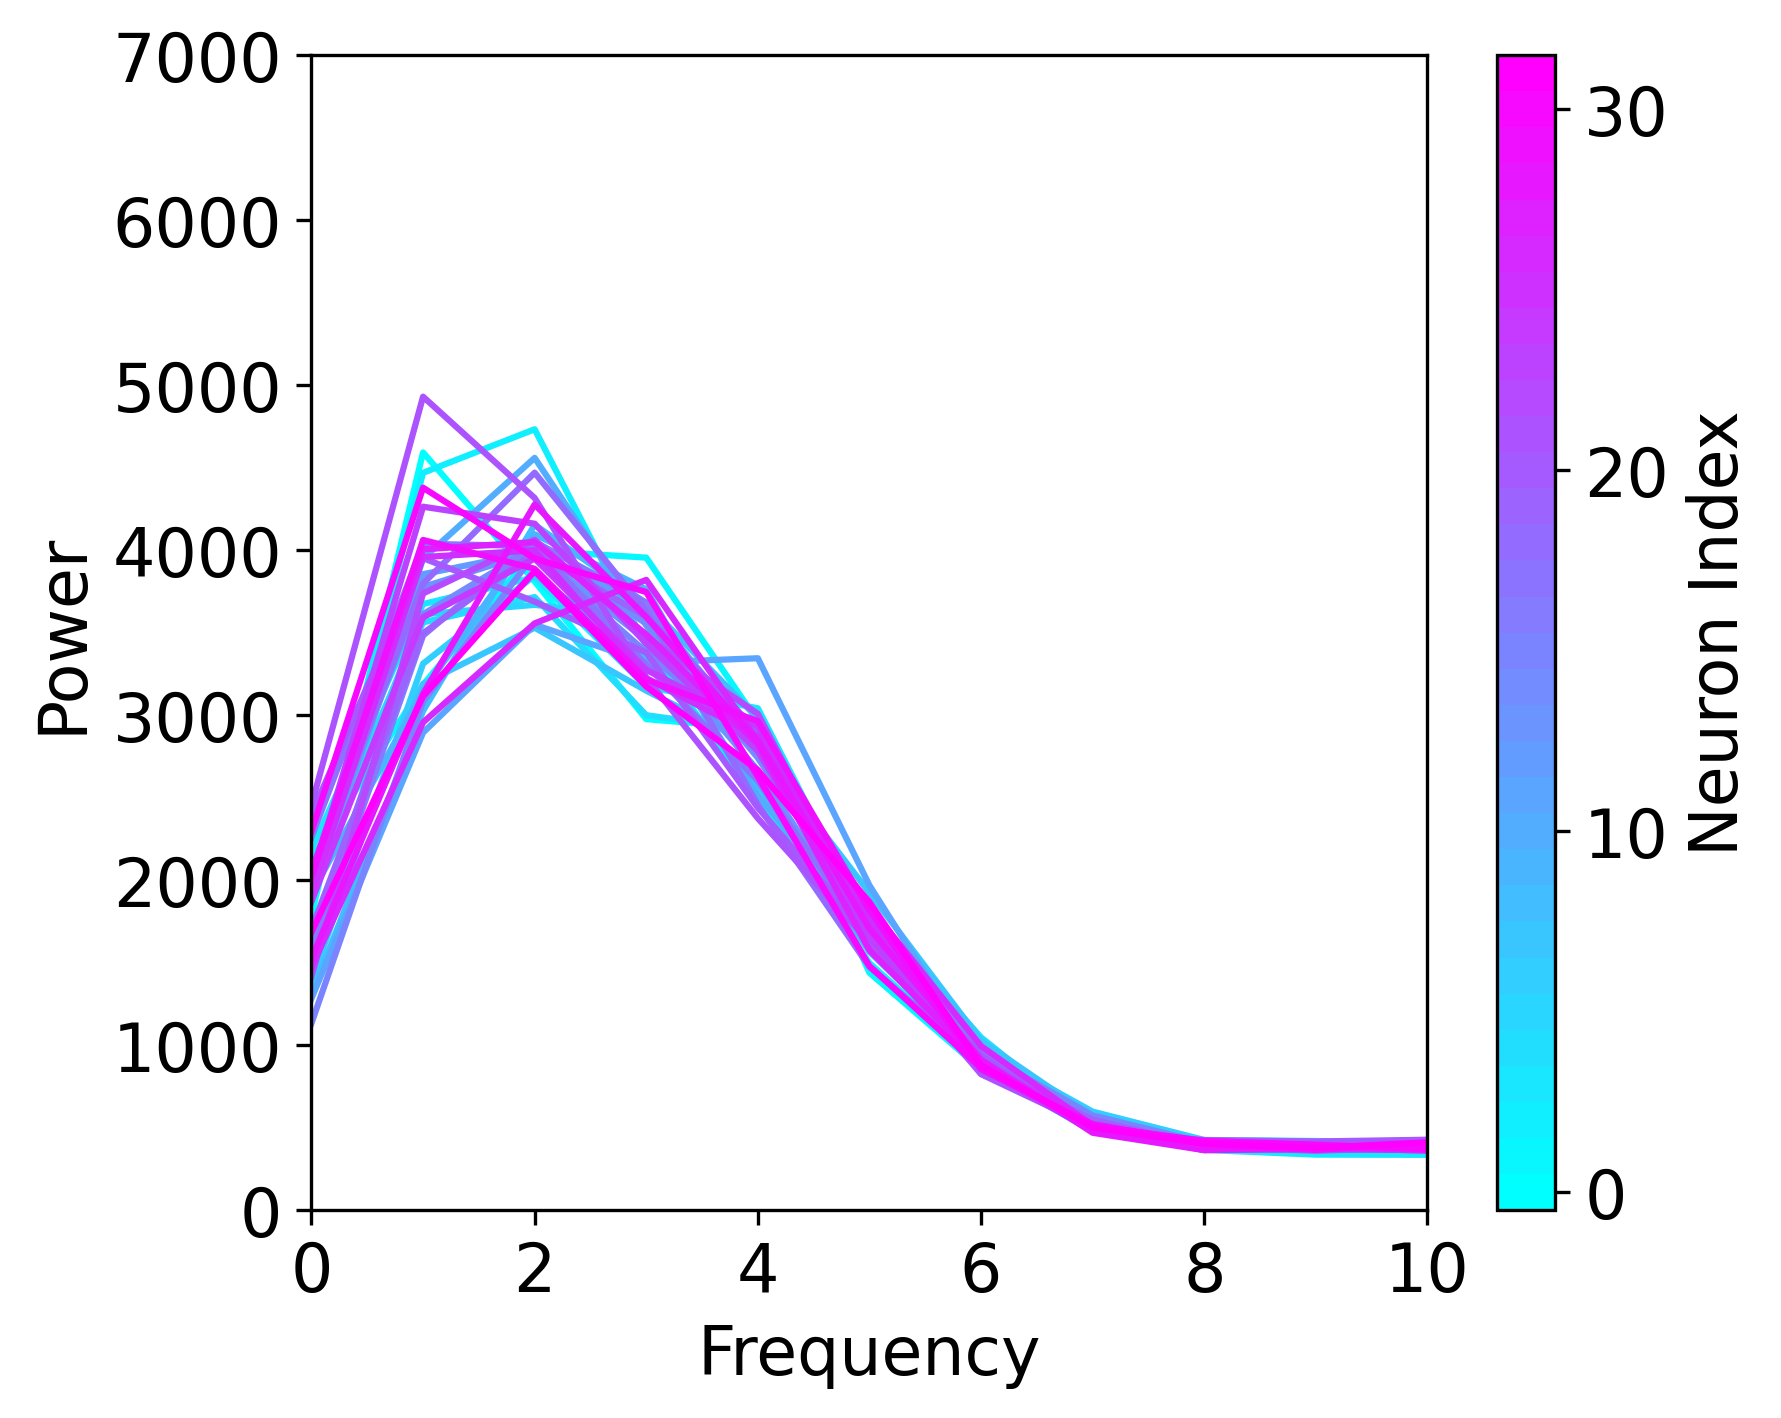

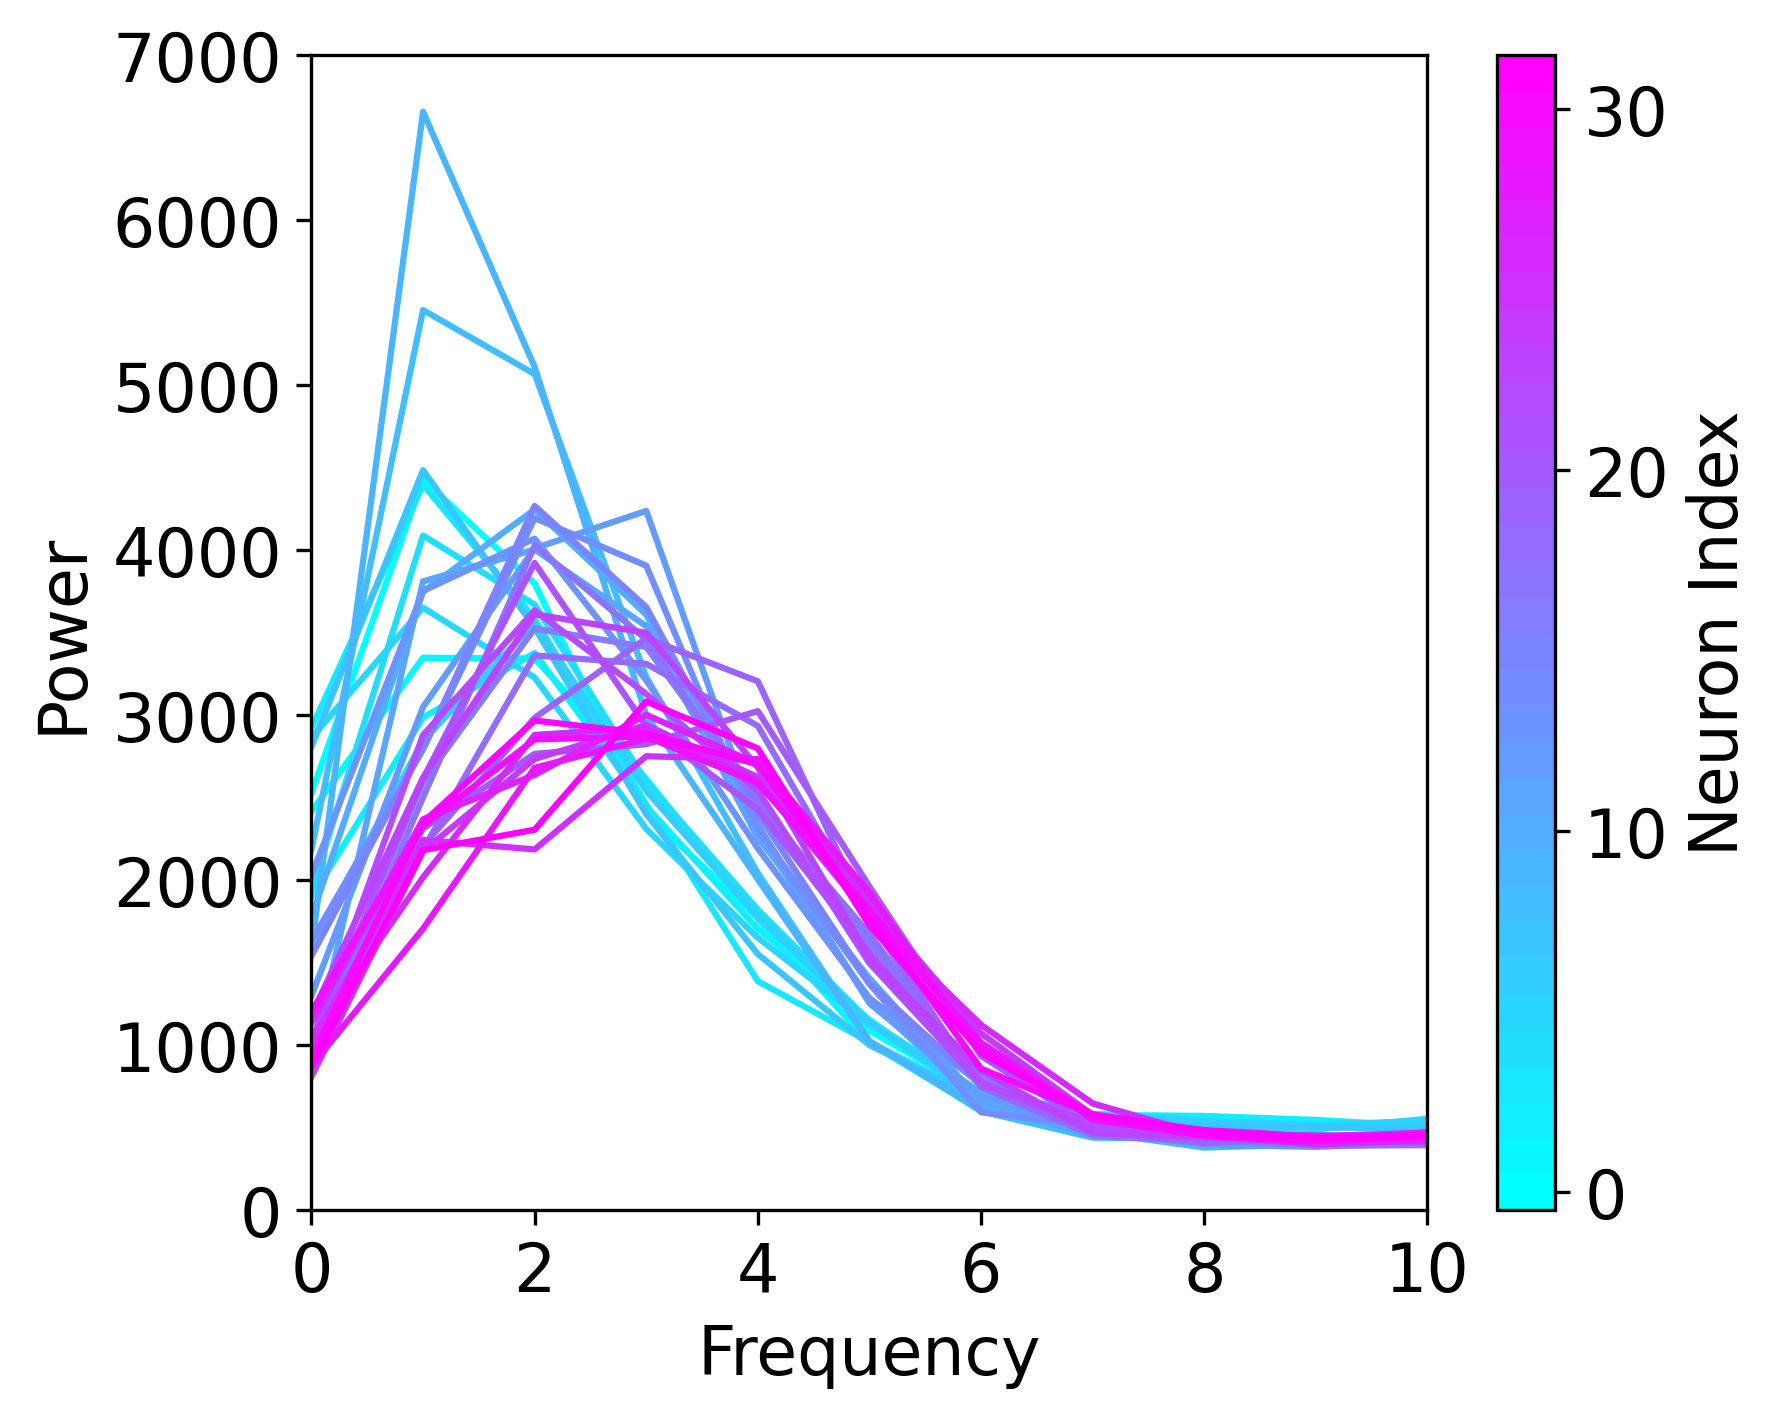

In [71]:
def plot_power_spectra(frequency_data, savepath, ylim_top=7000):
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    
    colors = plt.cm.cool(np.linspace(0, 1, 32))
    discrete_cmap = mcolors.ListedColormap(colors)
    bounds = np.arange(-0.5, 32.5, 1)
    
    for idx, freq in enumerate(frequency_data):
        ax.plot(freq, color=colors[idx], label=f'RF{idx + 1}')
    
    ax.set(xlabel='Frequency', 
           ylabel='Power',
           xlim=(0, 10),
           ylim=(0, ylim_top))
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    norm = mcolors.BoundaryNorm(bounds, discrete_cmap.N)
    sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, ticks=[0, 10, 20, 30])
    cbar.set_label('Neuron Index', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    cbar.minorticks_off()
    plt.savefig(savepath, bbox_inches='tight', dpi=300)
    plt.show()

plot_power_spectra(avg_sae_rf, 'Plots/l_sae_rf_power_spectrum.png')
plot_power_spectra(avg_dae_rf, 'Plots/l_dae_rf_power_spectrum.png')

TypeError: Colorbar.__init__() got an unexpected keyword argument 'font_size'

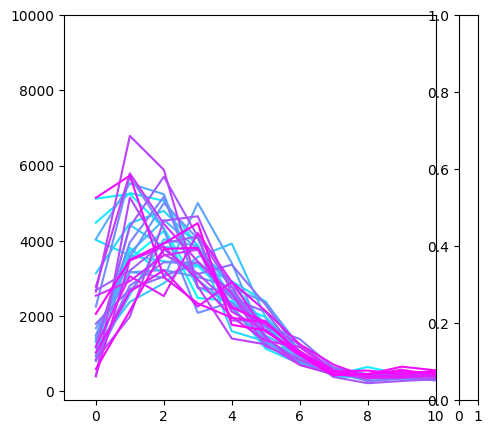

In [42]:
plot_power_spectra(srf_freq_ls)

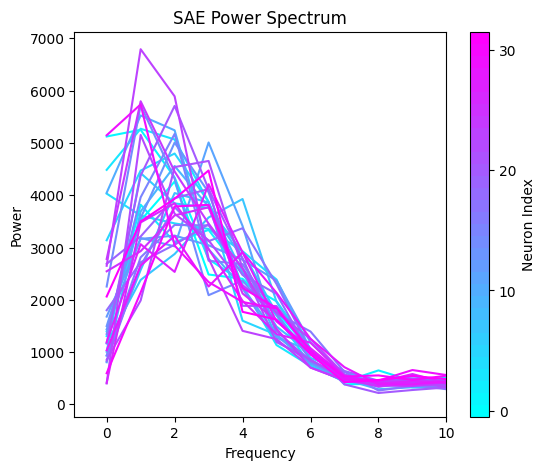

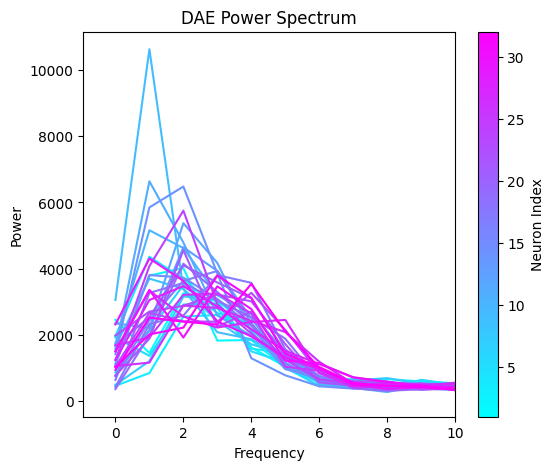

In [ ]:

srf_freq_ls = []
for srf in sae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(srf.reshape(28, 28)))
    srf_freq_ls.append(radial_avg)

drf_freq_ls = []
for drf in dae_rf_ls:
    radial_avg = power_spectrum_radial_average(z_score(drf.reshape(28, 28)))
    drf_freq_ls.append(radial_avg)

colors = plt.cm.cool(np.linspace(0, 1, 32))
discrete_cmap = mcolors.ListedColormap(colors)
bounds = np.arange(-0.5, 32.5, 1)

plot = plt.figure(figsize=(6, 5))
ax = plot.add_subplot(111)

for i, freq in enumerate(srf_freq_ls):
    ax.plot(freq, color=colors[i], label='RF' + str(i + 1))
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title('SAE Power Spectrum')
ax.set_xlim(right=10)

norm = mcolors.BoundaryNorm(bounds, discrete_cmap.N)
sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax, ticks=[0, 10, 20, 30])
colorbar.minorticks_off()
colorbar.set_label('Neuron Index')

plt.show()


colors = plt.cm.cool(np.linspace(0, 1, 32))

plot = plt.figure(figsize=(6, 5))
ax = plot.add_subplot(111)

for i, freq in enumerate(drf_freq_ls):
    ax.plot(freq, color=colors[i], label='RF' + str(i + 1))
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title('DAE Power Spectrum')
ax.set_xlim(right=10)

norm = plt.Normalize(vmin=1, vmax=32)
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
colorbar = plt.colorbar(sm, ax=ax, orientation='vertical')
colorbar.set_label('Neuron Index')

plt.show()

In [10]:
# Find threshold for a given power spectrum
# Threshold is the sum of the power spectrum / 2
# Find the frequency with the highest power
# Add the power of the neighbouring frequencies until the sum is greater than the threshold

power_spectrum = drf_freq_ls[20]

def peak_frequencies(power_spectrum):
    """
    Find the peak frequencies of a power spectrum.
    """

    threshold = sum(power_spectrum) / 2
    max_index = int(np.argmax(power_spectrum))

    current_sum = power_spectrum[max_index]

    i = max_index
    j = max_index

    while current_sum <= threshold:
        # Sum with the left neighbor
        if i - 1 >= 0:
            left_sum = current_sum + power_spectrum[i - 1]
        else:
            left_sum = current_sum  # No left neighbor
        
        # Sum with the right neighbor
        if j + 1 < len(power_spectrum):
            right_sum = current_sum + power_spectrum[j + 1]
        else:
            right_sum = current_sum  # No right neighbor

        # Check which side to add
        if left_sum > right_sum:
            current_sum = left_sum
            i -= 1
        else:
            current_sum = right_sum
            j += 1

        if current_sum > threshold:
            break

    return([*range(i, j + 1)])

for i, j in enumerate(drf_freq_ls):
    print(i, peak_frequencies(j))


0 [0, 1, 2, 3, 4]
1 [0, 1, 2, 3, 4]
2 [2, 3, 4, 5]
3 [0, 1, 2, 3]
4 [0, 1, 2, 3, 4]
5 [1, 2, 3, 4, 5]
6 [2, 3, 4]
7 [0, 1, 2, 3]
8 [1, 2]
9 [1, 2, 3]
10 [1, 2, 3]
11 [0, 1, 2, 3]
12 [2, 3, 4]
13 [1, 2, 3]
14 [1, 2, 3, 4]
15 [1, 2, 3, 4]
16 [1, 2, 3, 4]
17 [1, 2, 3, 4]
18 [1, 2, 3, 4]
19 [1, 2, 3, 4]
20 [1, 2, 3, 4]
21 [1, 2, 3, 4]
22 [1, 2, 3, 4, 5]
23 [1, 2, 3]
24 [1, 2, 3, 4]
25 [2, 3, 4, 5]
26 [1, 2, 3, 4, 5]
27 [1, 2, 3, 4]
28 [0, 1, 2, 3]
29 [1, 2, 3, 4]
30 [1, 2, 3, 4]
31 [2, 3, 4, 5]


In [31]:
def draw_circle(shape, diameter):
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)

def filter_circle(circle_mask, full_fft_filter):
    temp = np.zeros(full_fft_filter.shape,dtype=complex)
    temp[circle_mask] = full_fft_filter[circle_mask]
    return(temp)

def add_frequency_noise(image, noise_level=1, inner_diameter=3, outer_diameter=7):
    circle_mask         = draw_circle(shape=image.shape,diameter=inner_diameter)
    outer_circle_mask   = draw_circle(shape=image.shape, diameter=outer_diameter)
    ring_mask           = outer_circle_mask & ~circle_mask

    # FFT of the image
    fft_img = np.fft.fftshift(np.fft.fft2(image))

    # Noise in given frequency range
    # Old Method:
    # noise = np.random.randn(*image.shape)
    # noise = np.abs(noise_level * noise * ring_mask)

    fft_magnitude = np.abs(fft_img)
    mean_ring = np.mean(fft_magnitude[ring_mask])
    std_ring = np.std(fft_magnitude[ring_mask])

    noise = np.random.randn(*image.shape)
    noise = noise * std_ring + mean_ring

    noise = noise * ring_mask * noise_level

    # Combine noise and original FFT
    fft_with_noise = fft_img + noise

    img_reco = np.fft.ifft2(fft_with_noise)

    return np.abs(img_reco)

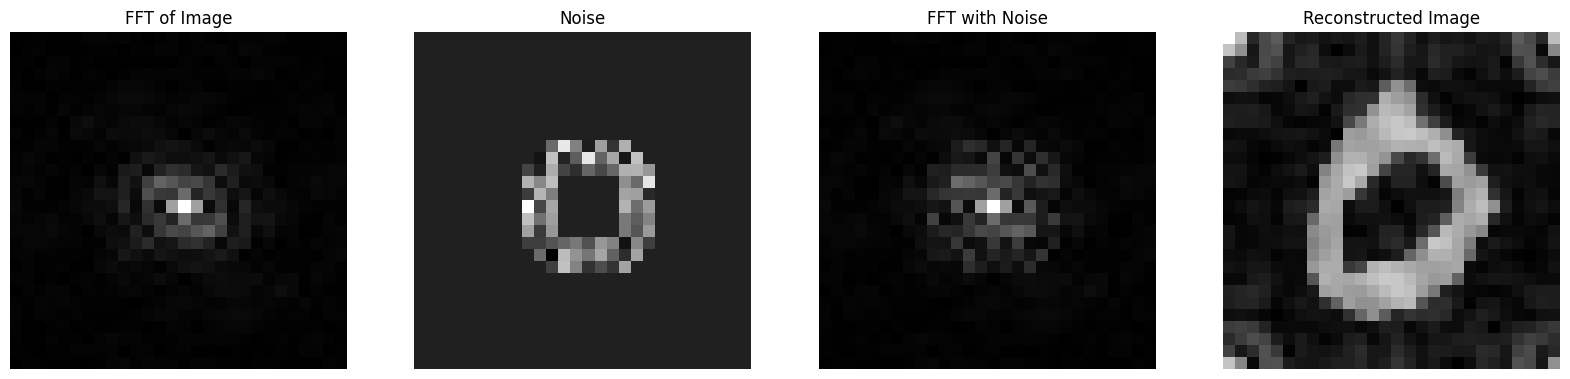

In [117]:
sample_image = test_images[3]
noise_level = 1
circle_mask         = draw_circle(shape=sample_image.shape,diameter=3)
outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=6)
ring_mask           = outer_circle_mask & ~circle_mask

# FFT of the image
fft_img = np.fft.fftshift(np.fft.fft2(sample_image))

fft_magnitude = np.abs(fft_img)
mean_ring = np.mean(fft_magnitude[ring_mask])
std_ring = np.std(fft_magnitude[ring_mask])

noise = np.random.randn(*sample_image.shape)
noise = noise * std_ring + mean_ring

noise = noise * ring_mask * noise_level

# Combine noise and original FFT
fft_with_noise = fft_img + noise

img_reco = np.fft.ifft2(fft_with_noise)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(np.abs(fft_img), cmap='gray')
axes[0].set_title('FFT of Image')
axes[0].axis('off')

axes[1].imshow(noise, cmap='gray')
axes[1].set_title('Noise')
axes[1].axis('off')

axes[2].imshow(np.abs(fft_with_noise), cmap='gray')
axes[2].set_title('FFT with Noise')
axes[2].axis('off')

axes[3].imshow(np.abs(img_reco), cmap='gray')
axes[3].set_title('Reconstructed Image')
axes[3].axis('off')

plt.show()


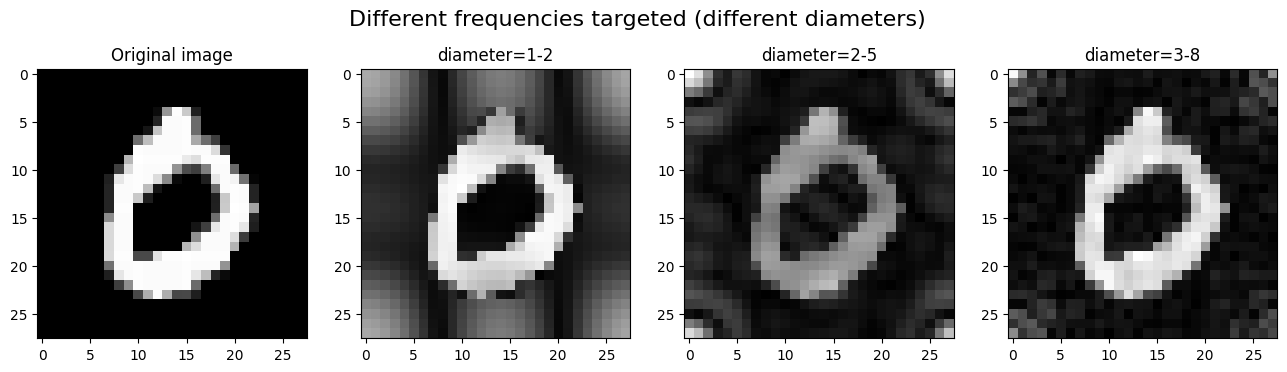

In [114]:
sample_image = test_images[3]

fig = plt.figure(figsize=(16, 4))
fig.suptitle("Different frequencies targeted (different diameters)", fontsize=16)

ax  = fig.add_subplot(1,4,1)
ax.imshow(sample_image, cmap='gray')
ax.set_title("Original image")

ax  = fig.add_subplot(1,4,2)
ax.imshow(add_frequency_noise(sample_image, noise_level=1, inner_diameter=1, outer_diameter=2), cmap='gray')
ax.set_title("diameter=1-2")

ax  = fig.add_subplot(1,4,3)
ax.imshow(add_frequency_noise(sample_image, noise_level=1, inner_diameter=2, outer_diameter=5), cmap='gray')
ax.set_title("diameter=2-5")

ax  = fig.add_subplot(1,4,4)
ax.imshow(add_frequency_noise(sample_image, noise_level=1, inner_diameter=5, outer_diameter=8), cmap='gray')
ax.set_title("diameter=3-8")

plt.show()

tensor([0.0000, 0.0000, 0.0374, 0.0000, 0.1754, 0.0901, 0.4072, 0.3631, 0.3426,
        0.2667, 0.0111, 0.6099, 0.0573, 0.0702, 0.1224, 0.1701, 0.0000, 0.0227,
        0.0000, 0.0618, 0.0000, 0.0000, 0.0117, 0.0180, 0.2486, 0.0000, 0.1680,
        0.3053, 0.0000, 0.0000, 0.2579, 0.4394])
tensor([0.0000, 0.0000, 0.0982, 0.0000, 0.2418, 0.0000, 0.3460, 0.3344, 0.2651,
        0.1778, 0.0384, 0.5535, 0.1021, 0.1215, 0.1742, 0.0754, 0.0000, 0.1465,
        0.0000, 0.0911, 0.0000, 0.0000, 0.0816, 0.0330, 0.2018, 0.0000, 0.1633,
        0.2668, 0.0000, 0.0000, 0.1863, 0.4138])


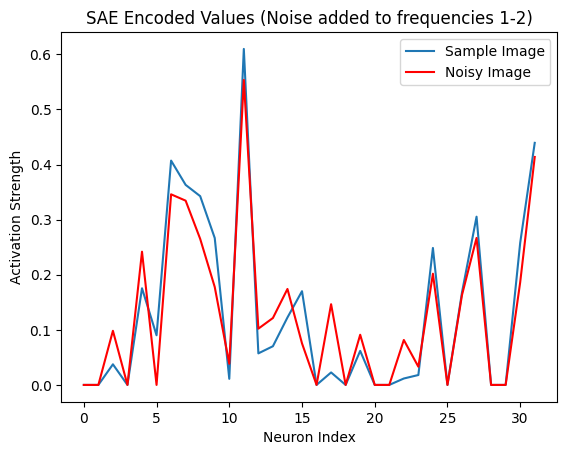

In [116]:
sample_image = test_images[3]
noisy_image = add_frequency_noise(sample_image, noise_level=1, inner_diameter=1, outer_diameter=2)

with torch.no_grad():
    sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
    noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)
    encoded, decoded = sae(sample_input)
    print(encoded)
    sae_sample_encoded = torch.abs(encoded)
    encoded, decoded = sae(noisy_input)
    sae_noisy_encoded = torch.abs(encoded)
    print(encoded)
    
plt.figure()
plt.plot(range(len(sae_sample_encoded)), sae_sample_encoded.cpu().numpy(), label='Sample Image')
plt.plot(range(len(sae_noisy_encoded)), sae_noisy_encoded.cpu().numpy(), color='red', label='Noisy Image')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Strength')
plt.title('SAE Encoded Values (Noise added to frequencies 1-2)')
plt.legend()
plt.show()

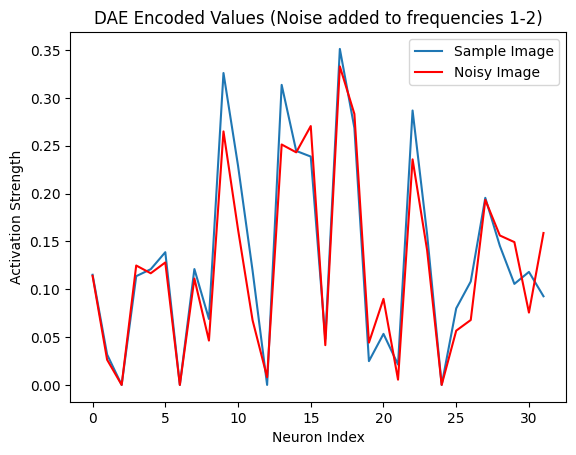

In [109]:
sample_image = test_images[3]
noisy_image = add_frequency_noise(sample_image, noise_level=1, inner_diameter=2, outer_diameter=5)

with torch.no_grad():
    sample_input = torch.tensor(sample_image, dtype=torch.float32).to('cpu').reshape(-1)
    noisy_input = torch.tensor(noisy_image, dtype=torch.float32).to('cpu').reshape(-1)
    encoded, decoded = dae(sample_input)
    dae_sample_encoded = torch.abs(encoded)
    encoded, decoded = dae(noisy_input)
    dae_noisy_encoded = torch.abs(encoded)
    
plt.figure()
plt.plot(range(len(dae_sample_encoded)), dae_sample_encoded.cpu().numpy(), label='Sample Image')
plt.plot(range(len(dae_noisy_encoded)), dae_noisy_encoded.cpu().numpy(), color='red', label='Noisy Image')
plt.xlabel('Neuron Index')
plt.ylabel('Activation Strength')
plt.title('DAE Encoded Values (Noise added to frequencies 1-2)')
plt.legend()
plt.show()

In [137]:
def evaluate_models(test_images, sae, dae):
    sae_diffs = []
    dae_diffs = []
    
    for i in range(len(test_images)):
        test_image = torch.tensor(test_images[i], dtype=torch.float32).reshape(-1)
        noisy_image = torch.tensor(add_frequency_noise(test_images[i], noise_level=1, inner_diameter=0, outer_diameter=3), dtype=torch.float32).reshape(-1)

        with torch.no_grad():
            encoded, _ = sae(test_image)
            sae_sample_encoded = torch.abs(encoded)
            encoded, _ = sae(noisy_image)
            sae_noisy_encoded = torch.abs(encoded)
            
            difference = torch.abs(sae_sample_encoded - sae_noisy_encoded)
            sae_diffs.append(difference)

            encoded, _ = dae(test_image)
            dae_sample_encoded = torch.abs(encoded)
            encoded, _ = dae(noisy_image)
            dae_noisy_encoded = torch.abs(encoded)
            
            difference = torch.abs(dae_sample_encoded - dae_noisy_encoded)
            dae_diffs.append(difference)
        
    return np.mean(np.vstack(sae_diffs), axis=0), np.mean(np.vstack(dae_diffs), axis=0)

In [14]:
def plot_noise_comparison(results, savepath):

    plt.figure(figsize=(12, 8), dpi=100)
    
    sae_data = np.vstack([run[0] for run in results])
    dae_data = np.vstack([run[1] for run in results])
    
    # Calculate statistics
    sae_mean = np.mean(sae_data, axis=0)
    sae_std = np.std(sae_data, axis=0)
    dae_mean = np.mean(dae_data, axis=0)
    dae_std = np.std(dae_data, axis=0)
    
    # Plot SAE
    plt.plot(sae_mean, color='blue', 
            label=f'SAE', linewidth=2)
    plt.fill_between(range(len(sae_mean)), 
                    sae_mean - sae_std, 
                    sae_mean + sae_std,
                    color='blue', alpha=0.1)
    
    # Plot DAE
    plt.plot(dae_mean, color='red', 
            label=f'DAE', linewidth=2)
    plt.fill_between(range(len(dae_mean)),
                    dae_mean - dae_std,
                    dae_mean + dae_std,
                    color='red', alpha=0.1)
    
    plt.xticks(fontsize=16)
    plt.yticks(np.arange(0, 0.06, 0.01), fontsize=16)
    plt.ylim(0, 0.05)
    
    plt.xlabel('Neuron Index', fontsize=16)
    plt.ylabel('Activation Differences between Regular and Noisy Images', fontsize=16)
#     plt.title('Neuron Activation Differences between SAE and DAE Models')
    plt.legend(fontsize=16, loc="upper right", frameon=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

In [138]:
results = []

for iteration in tqdm(range(10), desc=f"Processing models", leave=False):
    modelpath = f'/home/david/sparsify_models/nl_models/{iteration}'
    sae = load_model(modelpath, 'SAE', 49)
    dae = load_model(modelpath, 'DAE', 49)
    
    # Evaluate models
    sae_diffs, dae_diffs = evaluate_models(test_images, sae, dae)
    results.append((sae_diffs, dae_diffs))

Processing models:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_55422/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_p

In [139]:
np.save("saved_results/nl_frequency_noise_difference_0-3.npy", results)

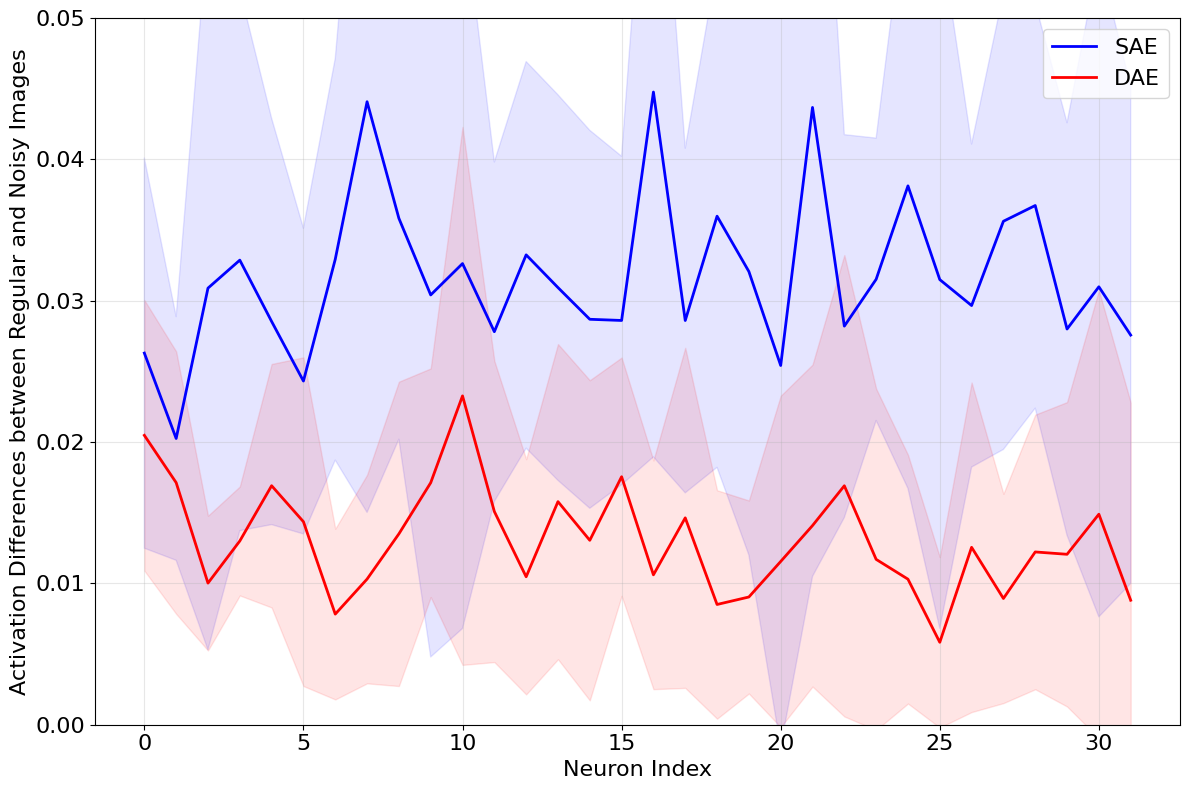

In [18]:
results = np.load("saved_results/l_frequency_noise_difference_0-3.npy", allow_pickle=True)

plot_noise_comparison(results, "Plots/l_frequency_noise_difference_0-3.png")